# Model Phase Plots

In [2]:
from asteria.simulation import Simulation
from asteria import set_rcparams

from snewpy.neutrino import Flavor
from scipy.interpolate import PchipInterpolator
import astropy.units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
asteria_env = 'ASTERIA' in os.environ

# set_rcparams(verbose=False)

In [3]:
if asteria_env:
    model = {'name': 'Nakazato_2013',
             'param':{
                 'progenitor_mass': 13 * u.Msun,
                 'revival_time': 300 * u.ms,
                 'metallicity': 0.02,
                 'eos': 'shen'}
             }
    
    sims = []
    mixing_schemes = ('AdiabaticMSW', 'AdiabaticMSW', 'NoTransformation')
    hierarchies = ('Normal', 'Inverted', None)
    
    for ms, h in zip(mixing_schemes, hierarchies):
        combo_str = f'{ms}:{h}' if h is not None else f'{ms}'
        print(f'Running Simulation for Combination: {combo_str}')
        
        sim = Simulation(model=model,
                         distance=10 * u.kpc, 
                         Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                         tmin=-10*u.s,  tmax=20*u.s, dt=1*u.ms,
                         mixing_scheme=ms, hierarchy=h)
        sim.run()
        sims.append(sim)

Running Simulation for Combination: AdiabaticMSW:Normal
Running Simulation for Combination: AdiabaticMSW:Inverted
Running Simulation for Combination: NoTransformation


In [4]:
if asteria_env:
    # Time limits for phases
    limits = [
        (-0.025, 0.100),
        (0.1, 0.6),
        (1, 10),
    ]

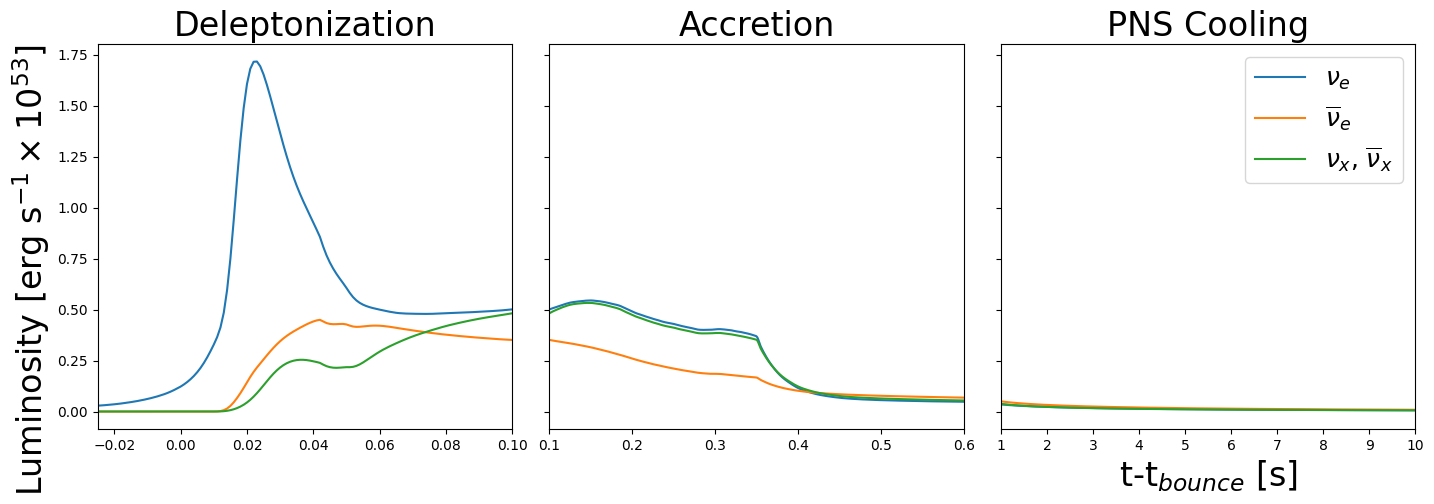

In [5]:
if asteria_env:
    titlesize=24
    lum_labels = [Flavor.NU_E.to_tex(), 
                  Flavor.NU_E_BAR.to_tex(), 
                  Flavor.NU_X.to_tex() +r', '+ Flavor.NU_X_BAR.to_tex()]
    
    # Initialize figure
    fig, axes = plt.subplots(1,3, figsize = (17,5), sharey=True, gridspec_kw = {'wspace':0.09})
    
    # Plot Luminosity
    ax = axes[0]
    sim = sims[0]
    t = sim.time
    
    for i, (ax, xlim) in enumerate(zip(axes, limits)):
        
        # Set ylabel only for left-most subplot
        if i == 0:
            ax.set_ylabel(r'Luminosity [erg s$^{-1} \times 10^{53}$]', horizontalalignment='right', y=1.0, fontsize=titlesize)
        for nu, flavor in enumerate(Flavor):
            if flavor.is_antineutrino and not flavor.is_electron:
                # Skips NU_X_BAR 
                continue
            
            lum = sim.source.luminosity(t, flavor).value/1e53
            ax.plot(t, lum, label=lum_labels[nu])
            ax.set(xlim=xlim)
    
    axes[0].set_title('Deleptonization', fontsize=titlesize)
    axes[1].set_title('Accretion', fontsize=titlesize)
    axes[2].set_title('PNS Cooling', fontsize=titlesize)
    axes[2].set_xlabel(r't-t$_{bounce}$ [s]', fontsize=titlesize)
    axes[2].legend(loc='upper right', ncol=1, fontsize = 18)

In [6]:
# outfile = f"../plots/{model['name']}_lum_phases"
# fig.savefig(outfile+'.png', format = 'png', bbox_inches="tight", dpi=300)
# fig.savefig(outfile+'.pdf', format = 'pdf', bbox_inches="tight")

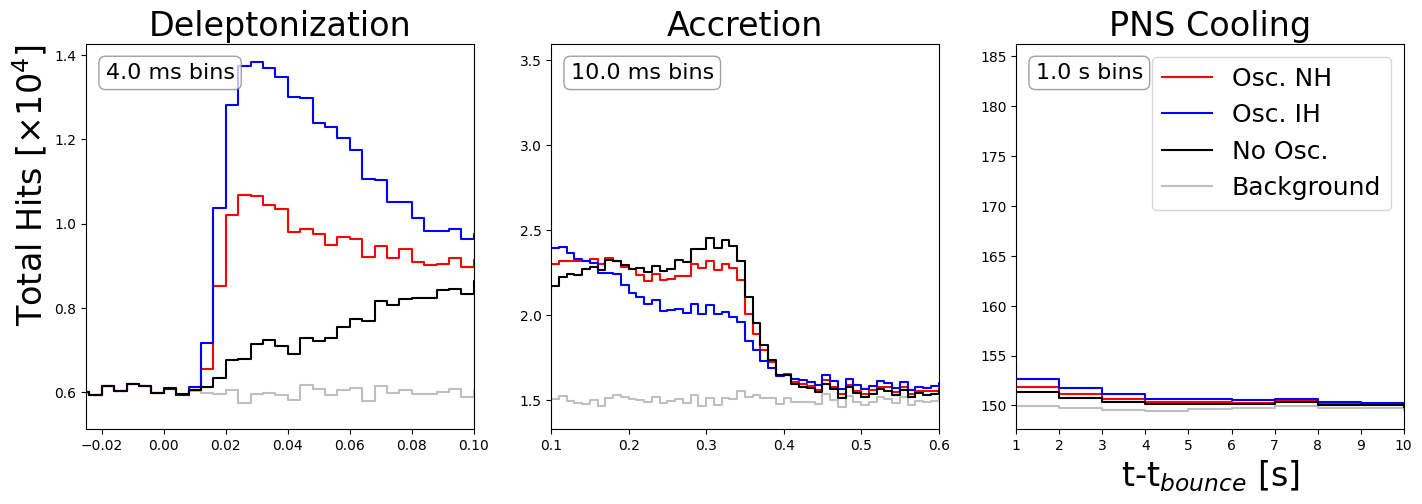

In [7]:
if asteria_env:
    titlesize=24
    scale = 1e4  # Manually adjust ylabel according to this
    ylabel = r'Total Hits [$\times 10^4$]'
    osc_labels = ['Osc. NH', 'Osc. IH', 'No Osc.']
    colors = ['r', 'b', 'k']
    binnings = [4e-3, 10e-3, 1] * u.s
    bbox_style = {'boxstyle': 'round', 'edgecolor': 'gray', 'facecolor': 'white', 'alpha': 0.75}
    
    # Plot hits
    fig, axes = plt.subplots(1,3, figsize = (17,5))
    
    for ax, binsize, xlim in zip(axes, binnings, limits):    
        bg = None
        # Simulations iterate by mixing scheme (see cell 2)
        for sim, label, color in zip(sims, osc_labels, colors):
    
            # Generate Signal hits
            t, dmu = sim.detector_hits(binsize)
            
            # Ensure the same background realization is used for each osc case
            if bg is None:
                bg = sim.detector.i3_bg(binsize, size=dmu.size) + sim.detector.dc_bg(binsize, size=dmu.size)
            
            hits = (dmu + bg)/scale        
            ax.step(t, hits, label=label, c=color)
        ax.step(t, bg/scale, label='Background', c='k', alpha=0.25)
        
        # Normalized to single dom rate in Hz
        # ax.step(t, bg/5160/binsize.to(u.s).value, label='Background', c='k', alpha=0.75)
        ax.set(xlim=xlim)
        if binsize <= 100 * u.ms:  
            scaled_binsize = binsize.to(u.ms)
            annotation = f'{scaled_binsize.value} {scaled_binsize.unit} bins'
        else:
           annotation = f'{binsize.value} {binsize.unit} bins'
        ax.text(0.05, 0.925, annotation, bbox=bbox_style, horizontalalignment='left', 
                verticalalignment='center', transform = ax.transAxes, fontsize=16)
    
    # Plot background
    axes[0].set_title('Deleptonization', fontsize=titlesize)
    axes[0].set_ylabel(ylabel, horizontalalignment='right', y=1.0, fontsize=titlesize)
    axes[1].set_title('Accretion', fontsize=titlesize)
    axes[2].set_title('PNS Cooling', fontsize=titlesize)
    axes[2].set_xlabel(r't-t$_{bounce}$ [s]', fontsize=titlesize)
    axes[2].legend(loc='upper right', ncol=1, fontsize = 18)

In [7]:
# outfile = f"../plots/{model['name']}_hits_phases"
# fig.savefig(outfile+'.png', format = 'png', bbox_inches="tight", dpi=300)
# fig.savefig(outfile+'.pdf', format = 'pdf', bbox_inches="tight")